
# Transporte de estados, los Centros de Wannier.


Para una descripción más precisa del fenómeno de bombeo, realizamos un seguimiento de la evolución de los centros de Wannier en el tiempo.

Definimos a los centros de Wannier como **el valor medio de la posición de los estados llenos**.


In [ ]:
from pylab import *

In [ ]:
%%capture
!pip install pythtb --upgrade

In [ ]:
from pythtb import *

In [ ]:
    a2 = array([ 1/2,sqrt(3)/2]) #vectores de red
    a3 = array([-1/2,sqrt(3)/2])
    a1 = a2-a3

    A1 = 2*a2
    A2 = 2*a3

In [ ]:
π   = pi                                  #Definimos parámetros que emplearemos a lo largo de nuestro trabajo 
C   = 77      # cm^-1               acoplamiento                 
κ   = 0.19    # μm^-1                      
δn0 = 0.05e-3   #amplitudes de modulación   #Energía de sitio, varía conel parámetro theta (índice de refracción)
L   = 50      # μm                          Separación entre guías vecinas
A   = 2.2     # μm                              
ϵ   = 1.469e4 # cm^-1

θ = π 

t = -2.7 # eV
β = 3.37 # parámetro de gruneissen 
ϵ = 0.05 # 50 meV
u = 0.2  # la deformación máxima es del 20%
acc = 1.42 # distancia carbono carbono

def func_cext(θ):
    return t*exp(-β*( acc*(1+u*cos(θ))/acc - 1 ))

def func_cint(θ):
    return t*exp(-β*( acc*(1-u*cos(θ))/acc - 1 ))

def func_δE(θ):
    return ϵ*sin(θ)

γ = 1.0 # 0.1*(1J)

In [ ]:
def hexaModel(θ):
  lat = [ A1, A2]
  orb = [ array([1,-1])/3, array([-1,1])/3, 
            array([1,0])/3, array([-1,0])/3, 
            array([0,1])/3, array([0,-1])/3  ]

  my_model = tb_model(2, 2, lat, orb)
  my_model.set_hop(func_cint(θ), 0, 2, [ 0, 0])
  my_model.set_hop(func_cint(θ), 1, 3, [ 0, 0])
  my_model.set_hop(func_cint(θ), 2, 4, [ 0, 0])
  my_model.set_hop(func_cint(θ), 3, 5, [ 0, 0])
  my_model.set_hop(func_cint(θ), 4, 1, [ 0, 0])
  my_model.set_hop(func_cint(θ), 5, 0, [ 0, 0])
    
  my_model.set_hop(func_cext(θ), 0, 1, [ 1,-1])
  my_model.set_hop(func_cext(θ), 2, 3, [ 1, 0])
  my_model.set_hop(func_cext(θ), 4, 5, [ 0, 1])
    
  # set on-site energies and hoppings
  ϵ1 = 1e-3
  ϵ2 = 1e-4
  my_model.set_onsite([γ*func_δE(θ)   ,-γ*func_δE(θ),        #términos en la diagonal del hamiltoniano
                    -γ*func_δE(θ)-ϵ1, γ*func_δE(θ)+ϵ1,
                     γ*func_δE(θ)+ϵ2,-γ*func_δE(θ)-ϵ2])
  return my_model


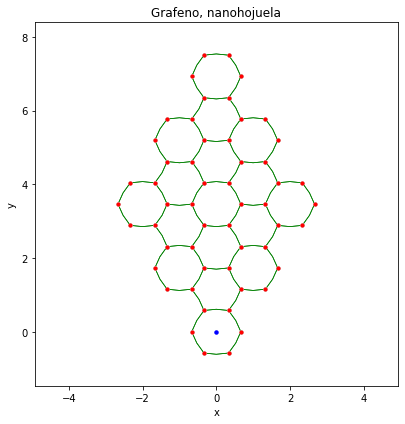

In [ ]:
# Repetición de la celda unitaria
L=3
hexa    = hexaModel(4*pi/3)
cut_one = hexa.cut_piece(L,0,glue_edgs=False)
cut_two = cut_one.cut_piece(L,1,glue_edgs=False)
# Visualización
(fig,ax)=cut_two.visualize(0,1)
ax.set_title("Grafeno, nanohojuela")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
fig.savefig("lat2x2.png",dpi=300)

In [ ]:
# Obtenemos las coordenadas del la red "cut_two"
A1,A2 = cut_two.get_lat()

X,Y = [],[]
for n in range(len(cut_two.get_orb())):
    x,y = dot(cut_two.get_orb()[n], (A1,A2))
    X.append(x)
    Y.append(y)
X = array(X)
Y = array(Y)
#print(X)

(-1.0, 15.0)

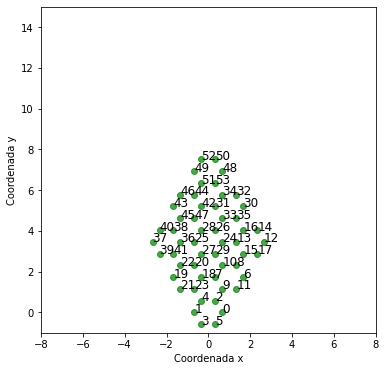

In [ ]:
# Graficar para ver quienes son los puntos de la red
fig, ax = plt.subplots(figsize=(6,6) )
ax.scatter(X,Y,c="green",alpha=0.7)
for n in range(len(X)):
    ax.text(X[n],Y[n],"{0}".format(n),fontsize=12)
ax.set_xlabel("Coordenada x")
ax.set_ylabel("Coordenada y")
ax.set_xlim(-8,8)
ax.set_ylim(-1,15)

In [ ]:
# Obtener eigenvalores del la red finita
# para todos los valores de θ
def ModeloHOTI(θ,L=3):
    my_model   = hexaModel(θ)
    cut_one = my_model.cut_piece(L,0,glue_edgs=False)
    cut_two = cut_one.cut_piece(L,1,glue_edgs=False)
    E,U    = cut_two.solve_all(eig_vectors=True)
    return E,U
#L    = 3
θ    = linspace(-π,π,1000)  # Intervalo de θ
DATA = list( map(ModeloHOTI,θ)) 

Datosθ = {}
for n in range(len(θ)):
  Datosθ[θ[n]] = {"E":DATA[n][0], "U":DATA[n][1]}

  #print(Datosθ)

In [ ]:
# L es el número de celdas unitarias
# es decir, la cadena tiene 6*L sitios
L=3; θspan=linspace(-π,π,1000)#linspace(0,1,200) 
# Operador posición     
#si no es periódico: POS=matrix(kron(diag(arange(1,L+1)),eye(2)))               
POS_X = matrix(kron(diag([1,2,3,2,3,4,3,4,5]),eye(6)))

LwanflowX = []

for θ in θspan: #valores por los que pasa t 
    #u,v,w = uvwNSCF(t)

    #H   = H_RM_reals(L,u,v,w)
    #sys = eigh(H)

   # H   = ModeloHOTI(θ)
    sys = ModeloHOTI(θ) #H.solve_all(eig_vectors=True)

    indFillBand = sys[0]<0
    #print (sys)
    Lval = sys[0][indFillBand] #eigenvalores negativos
    Lvec = matrix(sys[1][indFillBand]).T #eigenvectores negativos
    #Lvec = matrix(sys[1][:,indFillBand]) #eigenvectores negativos
    #print(shape (Lvec))

    LP = Lvec*Lvec.H
    LW = LP*POS_X*LP #multiplicación de matrices
    LWval,LWvec  = eig(LW) #eigenvalores
    indEigNoCero = abs(LWval)>1e-10
                  #Revisar aquí
    LwanflowX.append(sort(LWval[indEigNoCero]))
LwanflowX = array(LwanflowX)

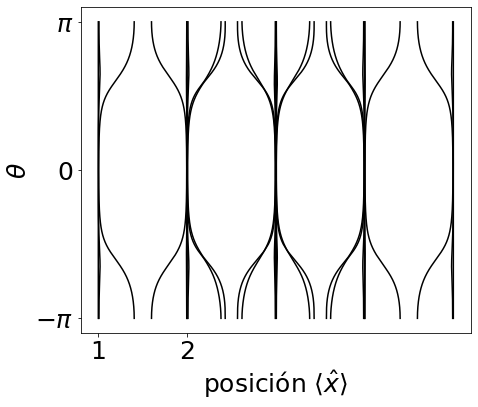

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))
for n in range(27):
 plot(real(LwanflowX.T[n]) , θspan, color='k' )

ax.set_yticks([-pi,0,pi])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
xlabel(r'posición $\langle \hat{x}\rangle$',fontsize=25);
ylabel(r'$\theta$',fontsize=25);

xticks(arange(1,L),fontsize=25)
yticks([-pi,0,pi],fontsize=25);
fig.savefig("WC66plot.png",dpi=300)

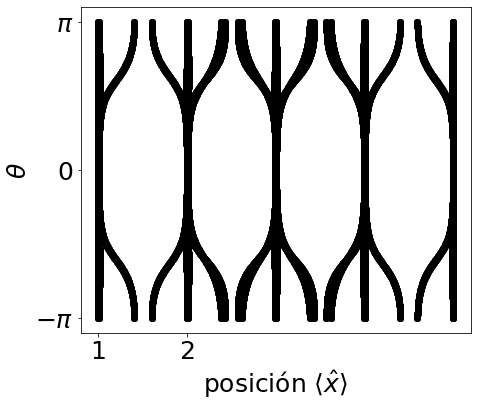

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))
for n in range(27):
#for n in range(int((6*L**2)/2)-1):
 scatter( real(LwanflowX.T[n]) , θspan,color='k' )
#xlabel(r'posición $\langle \hat{x}\rangle$',fontsize=25);
#ylabel(r"tiempo $t/T$",fontsize=25);

ax.set_yticks([-pi,0,pi])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
xlabel(r'posición $\langle \hat{x}\rangle$',fontsize=25);
ylabel(r'$\theta$',fontsize=25);

xticks(arange(1,L),fontsize=25)
yticks([-pi,0,pi],fontsize=25);

fig.savefig("WC66scat.png",dpi=300)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


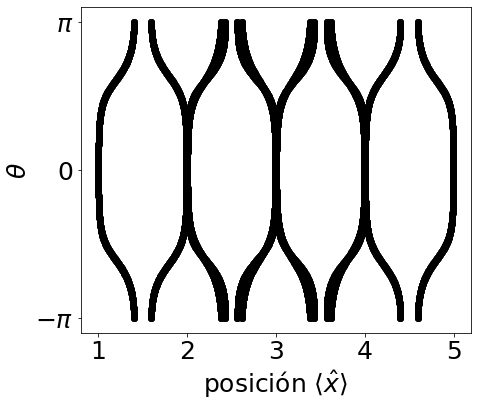

In [ ]:
L=6
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))
#for n in range(27):
#scatter( LwanflowX.T[n] , θspan )
#scatter( LwanflowX.T[0] , θspan )
#scatter( LwanflowX.T[1] , θspan )
scatter( LwanflowX.T[2] , θspan,color='k')
scatter( LwanflowX.T[3] , θspan,color='k')
#scatter( LwanflowX.T[4] , θspan )
#scatter( LwanflowX.T[5] , θspan )
#scatter( LwanflowX.T[6] , θspan )
scatter( LwanflowX.T[7] , θspan,color='k' )
scatter( LwanflowX.T[8] , θspan,color='k' )
scatter( LwanflowX.T[9] , θspan,color='k' )
scatter( LwanflowX.T[10] , θspan,color='k' )
#scatter( LwanflowX.T[11] , θspan )
#scatter( LwanflowX.T[12] , θspan )
#scatter( LwanflowX.T[13] , θspan )
#scatter( LwanflowX.T[14] , θspan )
#scatter( LwanflowX.T[15] , θspan ) #se empieza a mover
scatter( LwanflowX.T[16] , θspan,color='k' )
scatter( LwanflowX.T[17] , θspan,color='k' )
scatter( LwanflowX.T[18] , θspan,color='k' )
scatter( LwanflowX.T[19] , θspan,color='k' )
#scatter( LwanflowX.T[20] , θspan )
#scatter( LwanflowX.T[21] , θspan )
#scatter( LwanflowX.T[22] , θspan )
scatter( LwanflowX.T[23] , θspan,color='k' )
scatter( LwanflowX.T[24] , θspan,color='k' )
#scatter( LwanflowX.T[25] , θspan )
#scatter( LwanflowX.T[26] , θspan )



ax.set_yticks([-pi,0,pi])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
xlabel(r'posición $\langle \hat{x}\rangle$',fontsize=25);
ylabel(r'$\theta$',fontsize=25);

xticks(arange(1,L),fontsize=25)
yticks([-pi,0,pi],fontsize=25);
#xticks(arange(L)-L/2+0.5*mod(L,2),fontsize=25)
#yticks(linspace(0,3,5),fontsize=25);

fig.savefig("WC3x3.png",dpi=300)

El resultado muestra que durante un ciclo completo, cada centro de Wannier se mueve de una celda a otra, de derecha a izquierda y viceversa.

In [ ]:
# L es el número de celdas unitarias
# es decir, la cadena tiene 6*L sitios
L=6; θspan=linspace(0,1,200) #qué hace tspan?
#θ    = linspace(-π,π,1000)
# Operador posición     
#si no es periódico: POS=matrix(kron(diag(arange(1,L+1)),eye(2)))               
#POS_X = matrix(kron(diag([3,4,5,2,3,4,1,2,3]),(eye(6)))#-------Cambiar, no periódico 
POS_Y = matrix(kron(diag([1,2,3,2,3,4,3,4,5]),eye(6)))
#POS_Y = matrix(kron(diag([1,1,1,2,2,2,3,3,3]),eye(6)))

LwanflowY = []

for θ in θspan: #valores por los que pasa t 
    #u,v,w = uvwNSCF(t)

    #H   = H_RM_reals(L,u,v,w)
    #sys = eigh(H)

    #H   = ModeloHOTI(θ)
    sys = ModeloHOTI(θ)#H.solve_all(eig_vectors=True)

    indFillBand = sys[0]<0
    #print (sys)
    Lval = sys[0][indFillBand] #eigenvalores negativos
    Lvec = matrix(sys[1][indFillBand]).T #eigenvectores negativos
    #Lvec = matrix(sys[1][:,indFillBand]) #eigenvectores negativos
    #print(shape (Lvec))

    LP = Lvec*Lvec.H
    LW = LP*POS_Y*LP #multiplicación de matrices
    LWval,LWvec  = eig(LW) #eigenvalores
    indEigNoCero = abs(LWval)>1e-10
    
    LwanflowY.append(sort(LWval[indEigNoCero])  )
LwanflowY = array(LwanflowY)

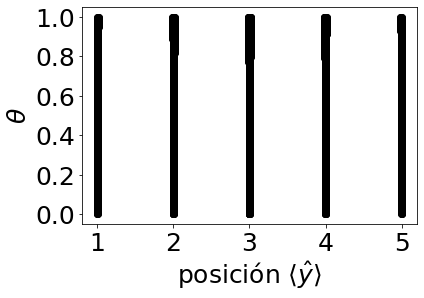

In [ ]:
for n in range(27):
  scatter( real(LwanflowY.T[n]) , θspan, color='k' )


ax.set_yticks([-pi,0,pi])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
xlabel(r'posición $\langle \hat{y}\rangle$',fontsize=25);
ylabel(r'$\theta$',fontsize=25);

xticks(arange(1,L),fontsize=25)
#yticks([-pi,0,pi],fontsize=25);
yticks(linspace(0,1,L,1),fontsize=25);